<br>
<h1 style = "font-size:60px; font-family:Garamond ; font-weight : normal; text-align: center; border-radius: 100px 100px;"> Predicting Pet Photo Pawpularity: A Deep Learning Approach on PetFinder.my</h1>
<br>

# THIS NOTEBOOK IS TO TRAIN MY MODEL, THIS IS THE MAIN CODE

# Install Required Libraries

In [1]:
!pip install git+https://github.com/rwightman/pytorch-image-models
!pip install --upgrade wandb
!pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/rwightman/pytorch-image-models to /tmp/pip-req-build-z69vdpjv
  Running command git clone --filter=blob:none --quiet https://github.com/rwightman/pytorch-image-models /tmp/pip-req-build-z69vdpjv
  Resolved https://github.com/rwightman/pytorch-image-models to commit e741370e2b95e0c2fa3e00808cd9014ee620ca62
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.10.0+cu113 (from versions: 1.11.0, 1.11.0+cu113, 1.12.0, 1.12.0+cu113, 1.12.1, 1.12.1+cu113, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2)
ERROR: No matching distribution found for torch==1.10.0+cu113


# Import Required Libraries

In [2]:
import os
import gc
import cv2
import copy
import time
import random
from PIL import Image

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold

import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

# Suppress warning messages
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Weights & Biases

In [3]:
import wandb

# Replace 'YOUR_WANDB_API_KEY' with your actual W&B API key
wandb_api_key = 'fb791f13096b7200ab0bda588a63209dd019718f'

try:
    # Login using your W&B API key
    wandb.login(key=wandb_api_key)
    anony = None
except wandb.errors.UsageError:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


wandb: Currently logged in as: svshreya02 (pawpularity1). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/oem/.netrc


In [4]:
ROOT_DIR = "/home/oem/Documents/CAPSTONE/"
TRAIN_DIR = "/home/oem/Documents/CAPSTONE/train"
TEST_DIR = "/home/oem/Documents/CAPSTONE/test"

# Training Configuration 

In [20]:
CONFIG = dict(
    seed = 42,
    model_name = 'tf_efficientnet_b4_ns',
    train_batch_size = 8,  # Reduced batch size
    valid_batch_size = 16,  # Reduced batch size if validation also causes memory issues
    img_size = 256,  # Reduced image size
    epochs = 5,
    learning_rate = 1e-4,
    scheduler = 'CosineAnnealingLR',
    min_lr = 1e-6,
    T_max = 100,
    T_0 = 25,
    warmup_epochs = 1,  # Added warmup epochs
    weight_decay = 1e-6,
    n_accumulate = 2,  # Using gradient accumulation to handle smaller batch sizes effectively
    n_fold = 5,
    num_classes = 1,
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    _wandb_kernel = 'deb'
)


# Set Seed for Reproducibility

In [21]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [22]:
def get_train_file_path(id):
    return f"{TRAIN_DIR}/{id}.jpg"

# Reading the Data 

In [23]:
df = pd.read_csv(f"{ROOT_DIR}/train.csv")
df['file_path'] = df['Id'].apply(get_train_file_path)

In [24]:
feature_cols = [col for col in df.columns if col not in ['Id', 'Pawpularity', 'file_path']]

# Visualize Images on W&B

In [9]:
run = wandb.init(project='Pawpularity', 
                 config=CONFIG,
                 job_type='Visualization',
                 group='Public_baseline',
                 anonymous='must')

In [10]:
preview_table = wandb.Table(columns=['Id', 'Image', 'Subject Focus', 'Eyes', 'Face', 
                                     'Near', 'Action', 'Accessory', 'Group', 'Collage', 
                                     'Human', 'Occlusion', 'Info', 'Blur', 'Pawpularity'])
tmp_df = df.sample(200, random_state=CONFIG['seed']).reset_index(drop=True)
for i in tqdm(range(len(tmp_df))):
    row = tmp_df.loc[i]
    img = Image.open(row.file_path)
    preview_table.add_data(row['Id'],
                           wandb.Image(img),
                           row['Subject Focus'],
                           row['Eyes'],
                           row['Face'],
                           row['Near'],
                           row['Action'],
                           row['Accessory'],
                           row['Group'],
                           row['Collage'],
                           row['Human'],
                           row['Occlusion'],
                           row['Info'],
                           row['Blur'],
                           row['Pawpularity'])

wandb.log({'Visualization': preview_table})
run.finish()

100%|█████████████████████████████████████████| 200/200 [00:37<00:00,  5.36it/s]


In [11]:
# display the W&B run page in this interactive session.
from IPython import display
from tqdm import tqdm

#simulate progress
for i in tqdm(range(10), desc="Loading W&B Run Page", unit="page"):
    # Simulate some work
    time.sleep(0.5)

iF = display.IFrame(run.url, width=1080, height=720)
iF


Loading W&B Run Page: 100%|███████████████████| 10/10 [00:05<00:00,  1.99page/s]


# Create Folds

In [25]:
def create_folds(df, n_s=5, n_grp=None):
    df['kfold'] = -1
    
    if n_grp is None:
        skf = KFold(n_splits=n_s, random_state=CONFIG['seed'])
        target = df['Pawpularity']
    else:
        skf = StratifiedKFold(n_splits=n_s, shuffle=True, random_state=CONFIG['seed'])
        df['grp'] = pd.cut(df['Pawpularity'], n_grp, labels=False)
        target = df.grp
    
    for fold_no, (t, v) in enumerate(skf.split(target, target)):
        df.loc[v, 'kfold'] = fold_no

    df = df.drop('grp', axis=1)
    
    return df

In [26]:
df = create_folds(df, n_s=CONFIG['n_fold'], n_grp=14)
df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,file_path,kfold
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,/home/oem/Documents/CAPSTONE/train/0007de18844...,0
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,/home/oem/Documents/CAPSTONE/train/0009c66b943...,1
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,/home/oem/Documents/CAPSTONE/train/0013fd999ca...,4
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,/home/oem/Documents/CAPSTONE/train/0018df346ac...,3
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,/home/oem/Documents/CAPSTONE/train/001dc955e10...,4


# Dataset Class

In [27]:
class PawpularityDataset(Dataset):
    def __init__(self, root_dir, df, transforms=None):
        self.root_dir = root_dir
        self.df = df
        self.file_names = df['file_path'].values
        self.targets = df['Pawpularity'].values
        self.meta = df[feature_cols].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        meta = self.meta[index, :]
        target = self.targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return img, meta, target

# Image Augmentations

In [28]:
import tensorflow as tf
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt

# Setting the size of the image
image_height = 128
image_width = 128

def display_image(image, title="Image"):
    plt.figure()
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()


In [29]:
def augment_and_display(image_path):
    # Initial loading and resizing
    raw = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(raw, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, (image_height, image_width))
    display_image(image.numpy(), "Original")


    tf_augmentations = [
        (tf.image.random_flip_left_right, "Flip Left Right"),
        (tf.image.random_flip_up_down, "Flip Up Down"),
        (lambda img: tf.image.rot90(img, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)), "Rotate"),
        (lambda img: tf.image.random_brightness(img, max_delta=0.5), "Brightness"),
        (lambda img: tf.image.random_contrast(img, lower=0.8, upper=1.2), "Contrast"),
        (lambda img: tf.image.random_saturation(img, lower=0.8, upper=1.2), "Saturation"),
        (lambda img: tf.image.random_hue(img, max_delta=0.3), "Hue")
    ]

    for aug, title in tf_augmentations:
        image = aug(image)
        display_image(image.numpy(), title)

    # Apply Albumentations augmentations (example with horizontal flip)
    # Convert TensorFlow tensor to NumPy array
    image_np = image.numpy()
    albumentation_aug = A.Compose([
        A.HorizontalFlip(p=1.0),
        # Add more Albumentations augmentations here
    ])
    augmented = albumentation_aug(image=image_np)
    image_np = augmented['image']
    display_image(image_np, "Albumentations - Horizontal Flip")

    # Convert back to TensorFlow tensor if needed
    image_tf = tf.convert_to_tensor(image_np, dtype=tf.float32)

    return image_tf  # or return image_np if you want the NumPy array

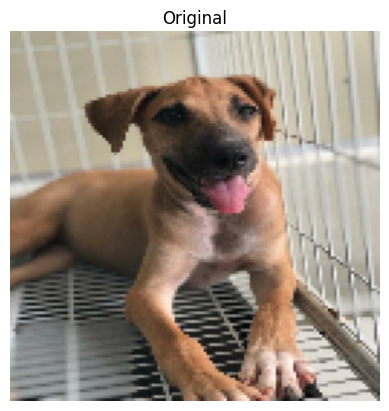

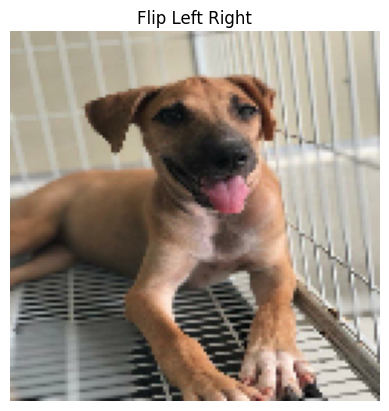

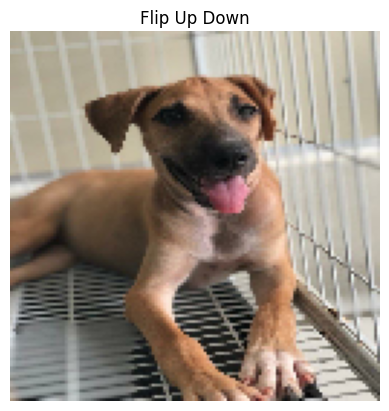

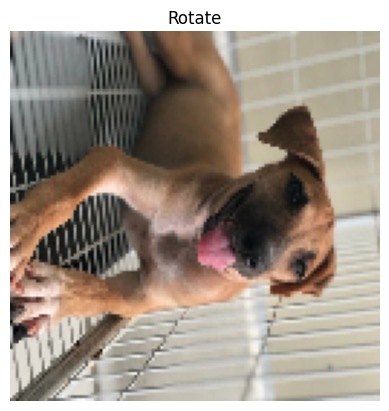

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


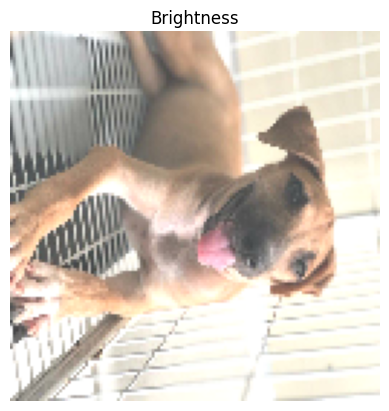

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


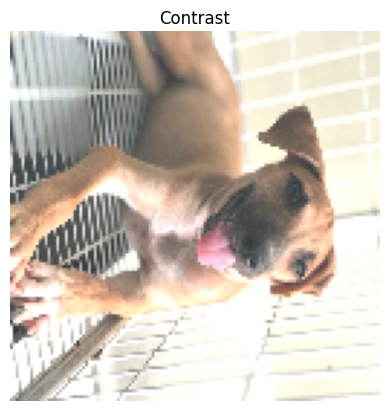

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


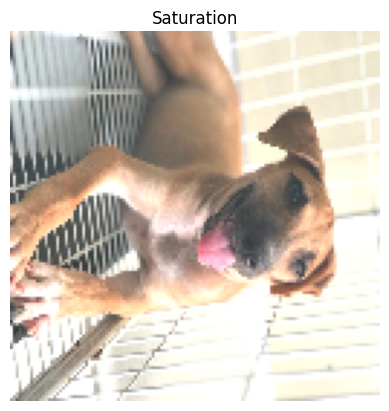

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


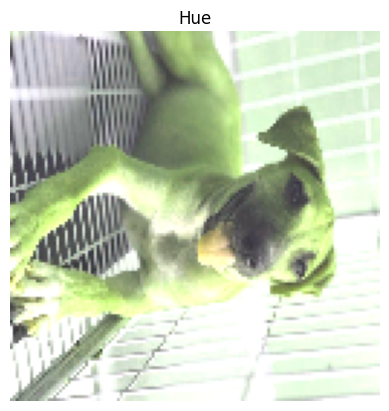

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


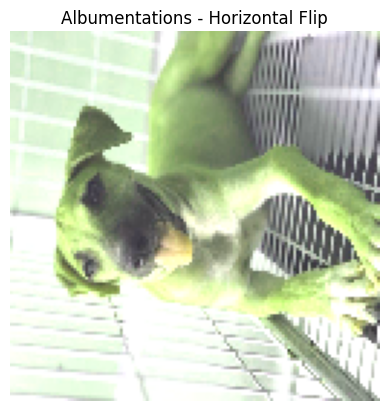

<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.837188  , 0.9367635 , 0.8134164 ],
        [0.837188  , 0.9367635 , 0.8134164 ],
        [0.8374562 , 0.93703175, 0.81368464],
        ...,
        [0.95900184, 1.0059708 , 0.9257966 ],
        [0.9547413 , 1.0112687 , 0.92150044],
        [0.8224758 , 0.9102743 , 0.7440542 ]],

       [[0.84979564, 0.9493711 , 0.826024  ],
        [0.8377245 , 0.9373    , 0.8139529 ],
        [0.8291407 , 0.9287162 , 0.8053691 ],
        ...,
        [0.95636934, 0.9660023 , 0.9236043 ],
        [0.9353113 , 0.9696907 , 0.9103533 ],
        [0.7748134 , 0.83187956, 0.7055343 ]],

       [[0.85006386, 0.9496393 , 0.8262922 ],
        [0.84577185, 0.94534737, 0.82200027],
        [0.8438942 , 0.9434697 , 0.8201226 ],
        ...,
        [0.9269055 , 0.9240373 , 0.9089886 ],
        [0.8741362 , 0.88847935, 0.86309564],
        [0.6807579 , 0.71740574, 0.6230654 ]],

       ...,

       [[0.88891315, 0.9126885 , 0.8840818 ],
        [0.87

In [30]:
# Example usage:
augment_and_display('/home/oem/Documents/CAPSTONE/train/00d1cb2ec8b263ae076ff95cae513a88.jpg')

# Create Model

In [31]:
class PawpularityModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super(PawpularityModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        self.fc = nn.LazyLinear(CONFIG['num_classes'])
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, images, meta):
        features = self.model(images)                 # features = (bs, embedding_size)
        features = self.dropout(features)
        features = torch.cat([features, meta], dim=1) # features = (bs, embedding_size + 12)
        output = self.fc(features)                    # outputs  = (bs, num_classes)
        return output
    
model = PawpularityModel(CONFIG['model_name'])
model.to(CONFIG['device']);

In [32]:
# dummy run to initialize the layers 
img = torch.randn(1, 3, CONFIG['img_size'], CONFIG['img_size']).to(CONFIG['device'])
meta = torch.randn(1, len(feature_cols)).to(CONFIG['device'])
model(img, meta)

tensor([[-0.0648]], grad_fn=<AddmmBackward0>)

# Loss Function

In [33]:
def criterion(outputs, targets):
    return torch.sqrt(nn.MSELoss()(outputs.view(-1), targets.view(-1)))

# Training Function

In [34]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, meta, targets) in bar:         
        images = images.to(device, dtype=torch.float)
        meta = meta.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            outputs = model(images, meta)
            loss = criterion(outputs, targets)
            loss = loss / CONFIG['n_accumulate']
            
        scaler.scale(loss).backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

# Validation Function

In [35]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    TARGETS = []
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, meta, targets) in bar:        
        images = images.to(device, dtype=torch.float)
        meta = meta.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        outputs = model(images, meta)
        loss = criterion(outputs, targets)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        PREDS.append(outputs.view(-1).cpu().detach().numpy())
        TARGETS.append(targets.view(-1).cpu().detach().numpy())
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])   
    
    TARGETS = np.concatenate(TARGETS)
    PREDS = np.concatenate(PREDS)
    val_rmse = mean_squared_error(TARGETS, PREDS, squared=False)
    gc.collect()
    
    return epoch_loss, val_rmse

# Run Training

In [36]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_rmse = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, val_epoch_rmse = valid_one_epoch(model, valid_loader, 
                                                         device=CONFIG['device'], 
                                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Valid RMSE'].append(val_epoch_rmse)
        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid RMSE": val_epoch_rmse})
        
        print(f'Valid RMSE: {val_epoch_rmse}')
        
        # deep copy the model
        if val_epoch_rmse <= best_epoch_rmse:
            print(f"{b_}Validation Loss Improved ({best_epoch_rmse} ---> {val_epoch_rmse})")
            best_epoch_rmse = val_epoch_rmse
            run.summary["Best RMSE"] = best_epoch_rmse
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "RMSE{:.4f}_epoch{:.0f}.bin".format(best_epoch_rmse, epoch)
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            wandb.save(PATH)
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best RMSE: {:.4f}".format(best_epoch_rmse))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [37]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = PawpularityDataset(TRAIN_DIR, df_train, transforms=data_transforms['train'])
    valid_dataset = PawpularityDataset(TRAIN_DIR, df_valid, transforms=data_transforms['valid'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=4, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=4, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [38]:
print(df.columns)


Index(['Id', 'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
       'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur', 'Pawpularity',
       'file_path', 'kfold'],
      dtype='object')


In [39]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

## Create Dataloaders

In [40]:
train_loader, valid_loader = prepare_loaders(fold=0)

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;">Define Optimizer and Scheduler</span>

In [41]:
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer)

In [42]:
run = wandb.init(project='Pawpularity', 
                 config=CONFIG,
                 job_type='Train',
                 group='Public_baseline',
                 anonymous='must')

## Start Training

In [43]:
model, history = run_training(model, optimizer, scheduler,
                              device=CONFIG['device'],
                              num_epochs=CONFIG['epochs'])

100%|███| 124/124 [02:13<00:00,  1.08s/it, Epoch=1, LR=1.88e-6, Valid_Loss=28.8]


Valid RMSE: 29.22184944152832
Validation Loss Improved (inf ---> 29.22184944152832)
Model Saved



100%|███| 124/124 [02:04<00:00,  1.01s/it, Epoch=2, LR=9.65e-5, Valid_Loss=21.3]


Valid RMSE: 21.874691009521484
Validation Loss Improved (29.22184944152832 ---> 21.874691009521484)
Model Saved



100%|███| 124/124 [02:08<00:00,  1.03s/it, Epoch=3, LR=8.71e-6, Valid_Loss=18.6]


Valid RMSE: 18.964805603027344
Validation Loss Improved (21.874691009521484 ---> 18.964805603027344)
Model Saved



100%|█████| 124/124 [02:05<00:00,  1.01s/it, Epoch=4, LR=8.66e-5, Valid_Loss=19]


Valid RMSE: 19.49083709716797



100%|███| 124/124 [02:06<00:00,  1.02s/it, Epoch=5, LR=2.14e-5, Valid_Loss=19.2]


Valid RMSE: 19.74013900756836

Training complete in 3h 50m 30s
Best RMSE: 18.9648


In [44]:
run.finish()

Train Loss,█▄▂▁▁
Valid Loss,█▃▁▁▁
Valid RMSE,█▃▁▁▂
Best RMSE,18.96481
Train Loss,7.15251
Valid Loss,19.23097
Valid RMSE,19.74014


In [45]:
model_save_path = '/home/oem/Documents/CAPSTONE/model_new.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /home/oem/Documents/CAPSTONE/model_new.pth


# Visualizations

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;"><a href="https://wandb.ai/pawpularity1/Pawpularity?nw=nwusersvshreya02">View the Complete Dashboard Here </a></span>

In [46]:
# This is just to display the W&B run page in this interactive session.
from IPython import display


iF = display.IFrame(run.url, width=1080, height=720)
iF

In [47]:
print(df)

                                    Id  Subject Focus  Eyes  Face  Near  \
0     0007de18844b0dbbb5e1f607da0606e0              0     1     1     1   
1     0009c66b9439883ba2750fb825e1d7db              0     1     1     0   
2     0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1   
3     0018df346ac9c1d8413cfcc888ca8246              0     1     1     1   
4     001dc955e10590d3ca4673f034feeef2              0     0     0     1   
...                                ...            ...   ...   ...   ...   
9880  ffbfa0383c34dc513c95560d6e1fdb57              0     0     0     1   
9881  ffcc8532d76436fc79e50eb2e5238e45              0     1     1     1   
9882  ffdf2e8673a1da6fb80342fa3b119a20              0     1     1     1   
9883  fff19e2ce11718548fa1c5d039a5192a              0     1     1     1   
9884  fff8e47c766799c9e12f3cb3d66ad228              0     1     1     1   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
0          0          0   